# Import necessary Libraries

In [1]:
import os
import glob
import trimesh
import numpy as np
import pandas as pd
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [2]:
DATA_DIR="C:/Users/mehed/.keras/datasets/ModelNet10"

In [3]:
print(DATA_DIR)

C:/Users/mehed/.keras/datasets/ModelNet10


In [4]:
print(os.listdir(DATA_DIR))

['.DS_Store', 'bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'README.txt', 'sofa', 'table', 'toilet']


In [5]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0010.off"))
mesh.show()

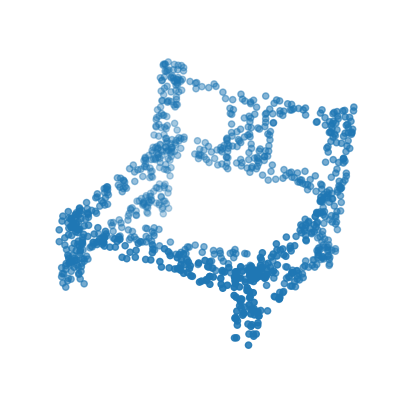

In [6]:
points = mesh.sample(1024)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [7]:
path=Path("C:\\Users\\mehed\\.keras\\datasets\\ModelNet10")

In [8]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

# Define dataset, data loader

# Function to Parse data
#Each mesh is loaded and sampled into a point cloud.
#Then returned as a numpy array

In [9]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "*[!README.txt]*"))
    print(folders)
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
       
        class_map[i] = folder.split("\\")[-1] 
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
     

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i) 

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

# Parse the dataset and process each class

In [10]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

['C:/Users/mehed/.keras/datasets/ModelNet10\\bathtub', 'C:/Users/mehed/.keras/datasets/ModelNet10\\bed', 'C:/Users/mehed/.keras/datasets/ModelNet10\\chair', 'C:/Users/mehed/.keras/datasets/ModelNet10\\desk', 'C:/Users/mehed/.keras/datasets/ModelNet10\\dresser', 'C:/Users/mehed/.keras/datasets/ModelNet10\\monitor', 'C:/Users/mehed/.keras/datasets/ModelNet10\\night_stand', 'C:/Users/mehed/.keras/datasets/ModelNet10\\sofa', 'C:/Users/mehed/.keras/datasets/ModelNet10\\table', 'C:/Users/mehed/.keras/datasets/ModelNet10\\toilet']
processing class: bathtub
processing class: bed
processing class: chair
processing class: desk
processing class: dresser
processing class: monitor
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [11]:
CLASS_MAP

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [12]:
# jitter and shuffle points
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, label

# generate tensors from the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
print(len(train_dataset))
print(len(test_dataset))

125
29


# Build the model

In [14]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [15]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

# Function to create t-net layers

#We applied here T-net 1 (output 3 x 3) is composed of a shared MLP (64, 128, 1024) network with same output sizes on each point followed by a max pooling and two dense layers with 512, 256 outputs. The output matrix is initialized as an Identity matrix. T-net 2 is similar with output 64 x 64.

In [16]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 512)
    x = dense_bn(x, 256)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="Identity",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

# Create the convolutional neural network (CNN)

In [17]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 64)
x = conv_bn(x, 64)

# T-net 2 with 64x64 output matrix
x = tnet(x, 64)

x = conv_bn(x, 64)
x = conv_bn(x, 128)
x = conv_bn(x, 1024)

x = layers.GlobalMaxPooling1D()(x)

x = dense_bn(x, 512)
#x = layers.Dropout(0.2)(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model1 = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model1.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 64)     256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 64)     0           ['batch_normalization[0][0

 activation_9 (Activation)      (None, 2048, 1024)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 1024)        0           ['activation_9[0][0]']           
 MaxPooling1D)                                                                                    
                                                                                                  
 dense_3 (Dense)                (None, 512)          524800      ['global_max_pooling1d_1[0][0]'] 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 512)         2048        ['dense_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activatio

# Train the model-1

In [18]:
# adam optimizer with initial learning rate 0.001, momentum 0.9, batch size 32.
# The learning rate is divided by 2 after every 5 epochs
def step_decay(epoch):
    lrate = 0.001
    step = 5
    if epoch > 5:
        lrate = lrate/(2 * (epoch//step))
    return lrate

model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0, beta_1=0.9, beta_2=0.999),
    metrics=["sparse_categorical_accuracy"],
)

checkpoints = keras.callbacks.ModelCheckpoint(filepath='pointnettest_weights_v5.hdf5',\
                                              monitor='val_sparse_categorical_accuracy',\
                                              mode='max',\
                                              save_best_only=True,\
                                              save_weights_only=True)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate, checkpoints]

model1.fit(train_dataset, epochs=15, validation_data=test_dataset, callbacks=callbacks_list)

Epoch 1/15
125/125 [==============================] - 40348s 325s/step - loss: 6.5584 - sparse_categorical_accuracy: 0.3155 - val_loss: 361337419678613504.0000 - val_sparse_categorical_accuracy: 0.2599 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - 653s 5s/step - loss: 4.2682 - sparse_categorical_accuracy: 0.3718 - val_loss: 1972053868544.0000 - val_sparse_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/15
125/125 [==============================] - 638s 5s/step - loss: 3.9147 - sparse_categorical_accuracy: 0.4545 - val_loss: 54511234187264.0000 - val_sparse_categorical_accuracy: 0.4703 - lr: 0.0010
Epoch 4/15
125/125 [==============================] - 636s 5s/step - loss: 3.9318 - sparse_categorical_accuracy: 0.4914 - val_loss: 38342504448.0000 - val_sparse_categorical_accuracy: 0.3194 - lr: 0.0010
Epoch 5/15
125/125 [==============================] - 637s 5s/step - loss: 3.7478 - sparse_categorical_accuracy: 0.5350 - val_loss: 363076939415552.0000 - val_sparse_ca

# Plot learning curves

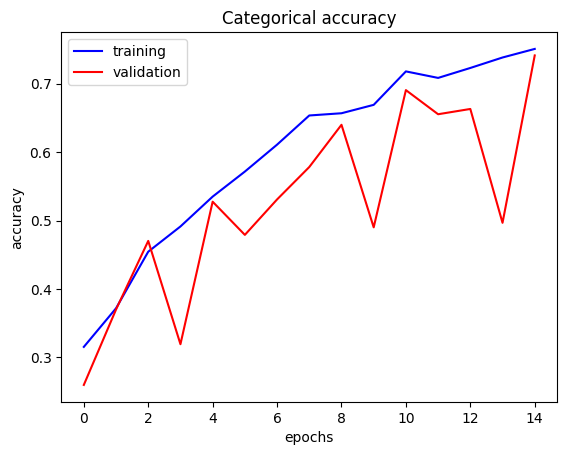

In [19]:
train_accuracy1 = model1.history.history['sparse_categorical_accuracy']
val_accuracy1 = model1.history.history['val_sparse_categorical_accuracy']
fig = plt.figure()
plt.plot(train_accuracy1, color='blue', label='training')
plt.plot(val_accuracy1, color='red', label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Categorical accuracy')
plt.legend(loc='best')
plt.show()

In [21]:
model1.load_weights("D:\Autumn_2023\ACIT_4030_(ML_Image and 3D data)\point_cloud\pointnettest_weights_v5.hdf5")
preds1 = model1.predict(test_dataset)
preds1 = tf.math.argmax(preds1,-1)
print('Validation accuracy: {}'.format(np.mean(test_labels == preds1)))

29/29 [==============================] - 19s 669ms/step
Validation accuracy: 0.7411894273127754


# Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

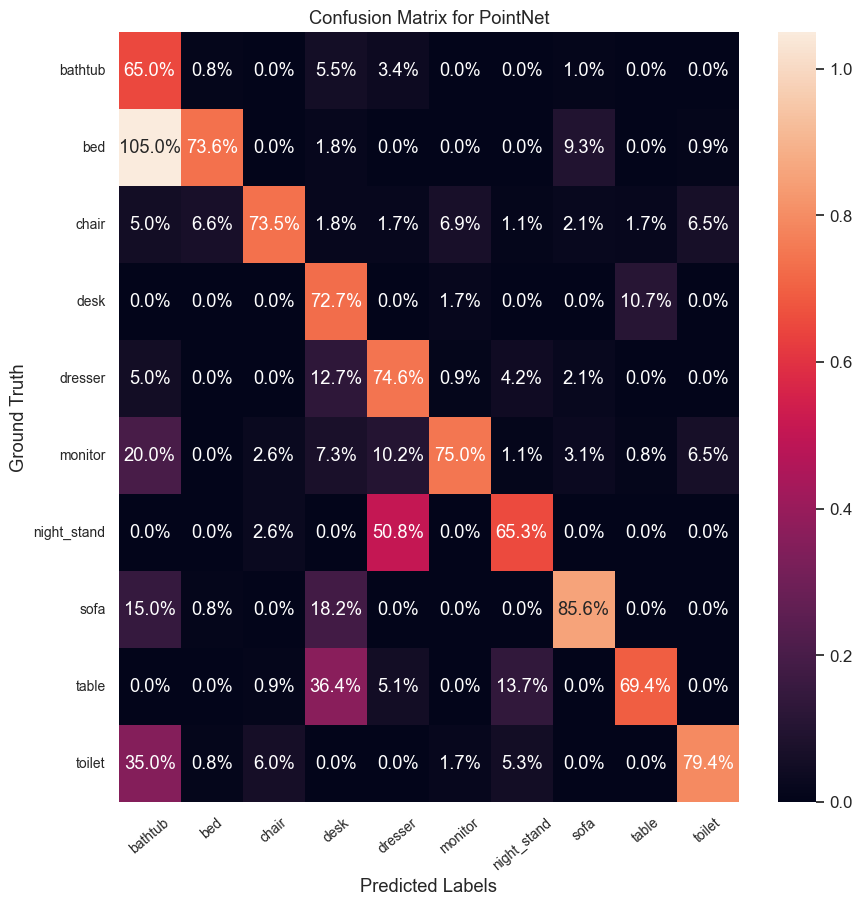

In [25]:
# confusion matrix
conf_matrix = confusion_matrix(preds1, test_labels)
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.1)
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.1%')
ax.set_xlabel('Predicted Labels')
ax.xaxis.set_ticklabels(list(CLASS_MAP.values()), fontsize=10, rotation=40)
ax.yaxis.set_ticklabels(list(CLASS_MAP.values()), fontsize=10, rotation=0)
ax.set_ylabel('Ground Truth')
ax.set_title('Confusion Matrix for PointNet')
plt.show()

# Model prediction and visualization

1/1 [==============================] - 0s 202ms/step


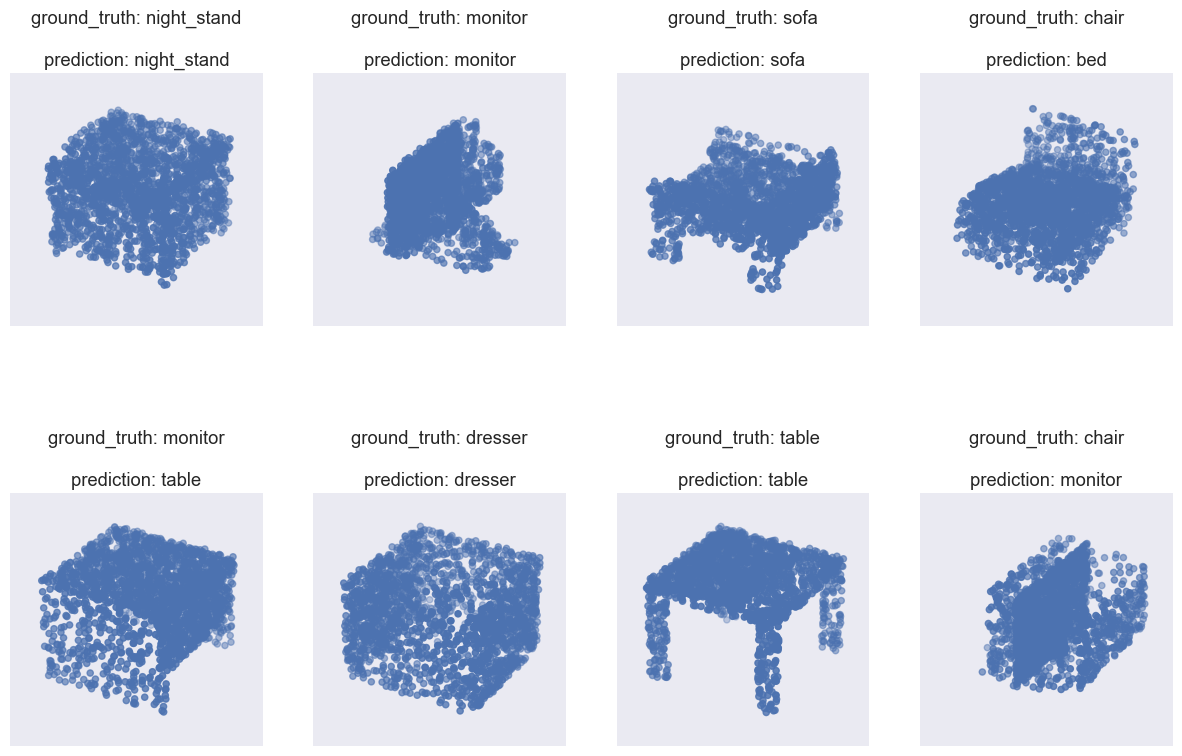

In [27]:
#shuffle test data
test_sample = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
test_sample = test_sample.shuffle(len(test_points)).batch(BATCH_SIZE)
# plotting model predictions
data = test_sample.take(8)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds1 = model1.predict(points)
preds1 = tf.math.argmax(preds1, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "ground_truth: {:}\n\nprediction: {:}".format(
            CLASS_MAP[preds1[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


# Model-2

In [28]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="Identity",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
   
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [29]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)

# T-net 2 with 32x32 output matrix
x = tnet(x, 32)

x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)

x = layers.GlobalMaxPooling1D()(x)

x = dense_bn(x, 256)
#x = layers.Dropout(0.2)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model2.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2048, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 2048, 32)    128         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 2048, 32)     0           ['batch_normalization_17[0

 activation_26 (Activation)     (None, 2048, 512)    0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 global_max_pooling1d_4 (Global  (None, 512)         0           ['activation_26[0][0]']          
 MaxPooling1D)                                                                                    
                                                                                                  
 dense_12 (Dense)               (None, 256)          131328      ['global_max_pooling1d_4[0][0]'] 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 256)         1024        ['dense_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activatio

# Training the model

In [41]:
# adam optimizer with initial learning rate 0.001, momentum 0.9, batch size 32.
# The learning rate is divided by 2 after every 5 epochs
def step_decay(epoch):
    lrate = 0.001
    step = 5
    if epoch > 5:
        lrate = lrate/(2 * (epoch//step))
    return lrate

model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0, beta_1=0.9, beta_2=0.999),
    metrics=["sparse_categorical_accuracy"],
)

checkpoints = keras.callbacks.ModelCheckpoint(filepath='pointnettest2_weights_v5.hdf5',\
                                              monitor='val_sparse_categorical_accuracy',\
                                              mode='max',\
                                              save_best_only=True,\
                                              save_weights_only=True)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate, checkpoints]

model2.fit(train_dataset, epochs=15, validation_data=test_dataset, callbacks=callbacks_list)

Epoch 1/15
125/125 [==============================] - 455s 3s/step - loss: 2.3778 - sparse_categorical_accuracy: 0.6159 - val_loss: 4268666153229877248.0000 - val_sparse_categorical_accuracy: 0.6333 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - 432s 3s/step - loss: 2.2036 - sparse_categorical_accuracy: 0.6442 - val_loss: 4663294895211937792.0000 - val_sparse_categorical_accuracy: 0.5738 - lr: 0.0010
Epoch 3/15
125/125 [==============================] - 11371s 92s/step - loss: 2.1161 - sparse_categorical_accuracy: 0.6703 - val_loss: 748966843536455499776.0000 - val_sparse_categorical_accuracy: 0.6586 - lr: 0.0010
Epoch 4/15
125/125 [==============================] - 26656s 215s/step - loss: 2.0684 - sparse_categorical_accuracy: 0.6893 - val_loss: 13057965162496.0000 - val_sparse_categorical_accuracy: 0.7137 - lr: 0.0010
Epoch 5/15
125/125 [==============================] - 1211s 10s/step - loss: 2.0524 - sparse_categorical_accuracy: 0.7008 - val_loss: 4035339091968.

# Plot learning curve

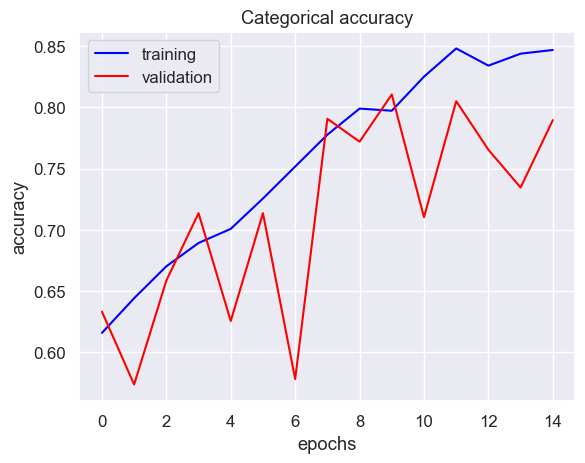

In [42]:
train_accuracy2 = model2.history.history['sparse_categorical_accuracy']
val_accuracy2 = model2.history.history['val_sparse_categorical_accuracy']
fig = plt.figure()
plt.plot(train_accuracy2, color='blue', label='training')
plt.plot(val_accuracy2, color='red', label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Categorical accuracy')
plt.legend(loc='best')
plt.show()

In [43]:
model2.load_weights("D:\Autumn_2023\ACIT_4030_(ML_Image and 3D data)\point_cloud\pointnettest2_weights_v5.hdf5")
preds2 = model2.predict(test_dataset)
preds2 = tf.math.argmax(preds2,-1)
print('Validation accuracy: {}'.format(np.mean(test_labels == preds2)))

29/29 [==============================] - 9s 280ms/step
Validation accuracy: 0.8105726872246696


In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

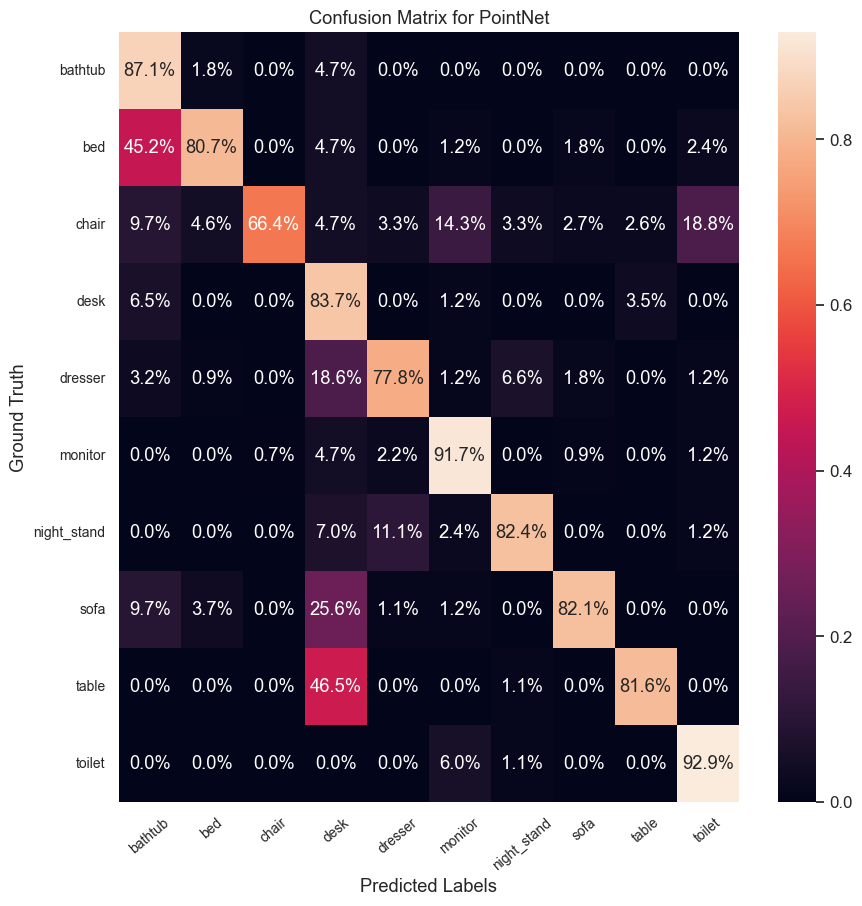

In [45]:
# confusion matrix
conf_matrix = confusion_matrix(preds2, test_labels)
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.1)
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.1%')
ax.set_xlabel('Predicted Labels')
ax.xaxis.set_ticklabels(list(CLASS_MAP.values()), fontsize=10, rotation=40)
ax.yaxis.set_ticklabels(list(CLASS_MAP.values()), fontsize=10, rotation=0)
ax.set_ylabel('Ground Truth')
ax.set_title('Confusion Matrix for PointNet')
plt.show()

1/1 [==============================] - 1s 856ms/step


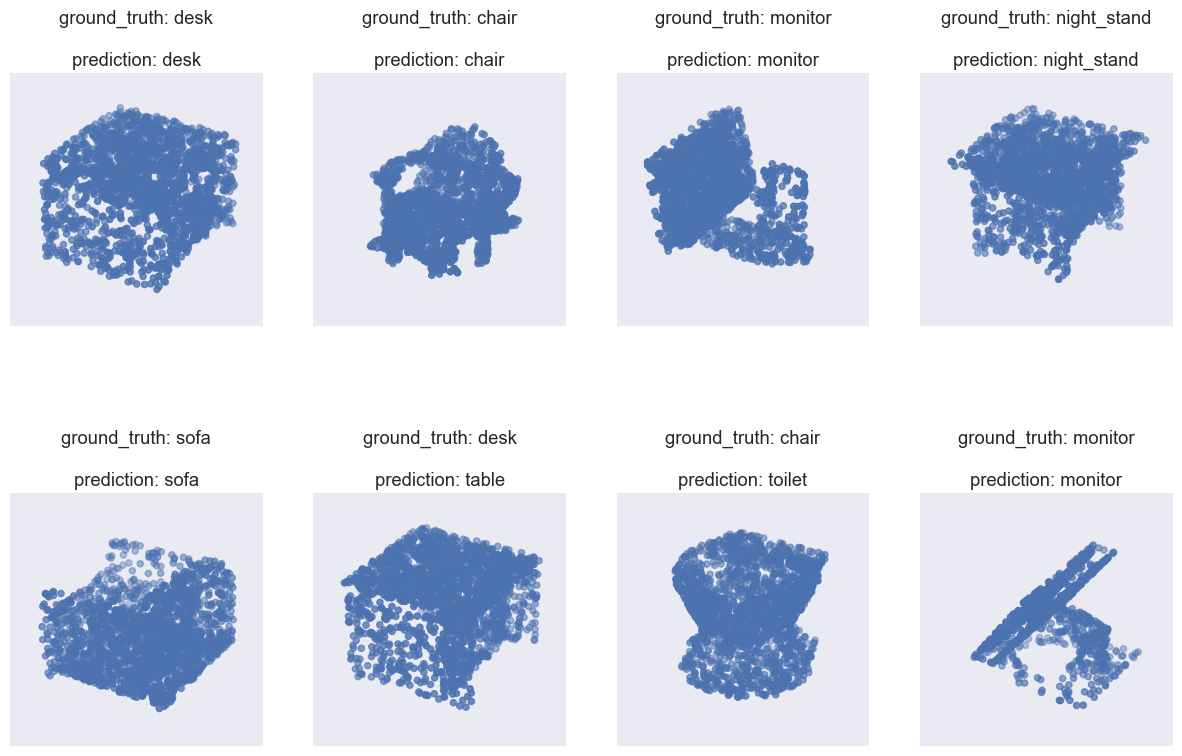

In [46]:
#shuffle test data
test_sample = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
test_sample = test_sample.shuffle(len(test_points)).batch(BATCH_SIZE)
# plotting model predictions
data = test_sample.take(8)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds2 = model2.predict(points)
preds2 = tf.math.argmax(preds2, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "ground_truth: {:}\n\nprediction: {:}".format(
            CLASS_MAP[preds2[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++